In [2]:
import numpy as np
import torch
import deeplay as dl
import torchvision
import PIL
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import os
import warnings
from sklearn.exceptions import ConvergenceWarning


In [3]:

def read_mnist_txt(file_path):
    """Read MNIST-like data from text file"""
    images = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split()
            image_num = parts[0].strip('"')
            label = int(parts[1])
            
            # Validate label range
            if label < -9 or label > 9:
                raise ValueError(f"Invalid label {label} found in the dataset.")
            
            pixels = list(map(float, parts[2:]))
            pixel_array = np.array(pixels).reshape(16, 16)
            images.append(pixel_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate(random_state, images, labels, train_fn, predict_fn, k_folds=5, metric_fn=accuracy_score):
    """
    Generic cross-validation.

    Args:
        images (np.ndarray): Image data.
        labels (np.ndarray): Corresponding labels.
        train_fn (callable): Function to train a model. Signature: (train_images, train_labels) -> model
        predict_fn (callable): Function to predict. Signature: (model, test_images) -> predictions
        k_folds (int): Number of folds (default 5).
        metric_fn (callable): Evaluation metric function. Signature: (true_labels, predicted_labels) -> float

    Returns:
        List of scores for each fold.
    """
    all_scores = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = random_state)

    for fold, (train_idx, val_idx) in enumerate(kf.split(images)):

        train_images, val_images = images[train_idx], images[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Train and predict
        model = train_fn(train_images, train_labels)
        predictions = predict_fn(model, val_images)

        # Score
        score = metric_fn(val_labels, predictions)
        all_scores.append(score)

    return all_scores


In [5]:
#modified PCA to work with cross-validator
def dataPrep(images, labels, test_size=200):
    """Prepare and split data into train/test sets"""
    randomIndices = np.random.permutation(len(images))
    images = np.array(images)[randomIndices]
    labels = np.array(labels)[randomIndices]

    trainingSet = images[:len(images)-test_size]
    trainingLabels = labels[:len(images)-test_size]
    testSet = images[-test_size:]
    testSetLabels = labels[-test_size:]
    
   
    
    return trainingSet, trainingLabels, testSet, testSetLabels


def dimRedPCA(trainingSet, testSet=None, trainVariance=.95):
    """Modified to consistently return (data, pca) or (train_data, test_data, pca)"""
    xTrain = trainingSet.reshape(len(trainingSet), -1)
    pca = PCA(n_components=trainVariance)
    trainPCA = pca.fit_transform(xTrain)
    
    if testSet is None:
        return trainPCA, pca  # Return PCA object when no test set
    else:
        xTest = testSet.reshape(len(testSet), -1)
        return trainPCA, pca.transform(xTest), pca

def train_PCA(train_images, train_labels, max_iter=5000):
    """Training function that handles PCA and suppresses convergence warnings"""
    train_flat = train_images.reshape(len(train_images), -1)
    train_pca, pca = dimRedPCA(train_flat)  # Returns train data + PCA object

    clf = MLPClassifier(solver='sgd', activation='logistic', max_iter=max_iter)

    # Suppress convergence warning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf.fit(train_pca, train_labels)

    return clf, pca

def predict_with_PCA(model_tuple, test_images):
    """Prediction function that applies PCA"""
    clf, pca = model_tuple
    test_flat = test_images.reshape(len(test_images), -1)
    test_pca = pca.transform(test_flat)
    return clf.predict(test_pca)

def logisticNNPCA(filePath='Numbers.txt', trainVariance=.95):
    """Original pipeline function"""
    images, labels = read_mnist_txt(filePath)
    trainingSet, trainingLabels, testSet, testSetLabels = dataPrep(images, labels)
    trainPCA, testPCA = dimRedPCA(trainingSet, testSet, trainVariance)
    
    model = train_PCA(trainPCA, trainingLabels)
    predictedLabels = predict_with_PCA(model, testPCA, testSetLabels)
    
    return predictedLabels

100
200
500
1000
3000
5000
10000


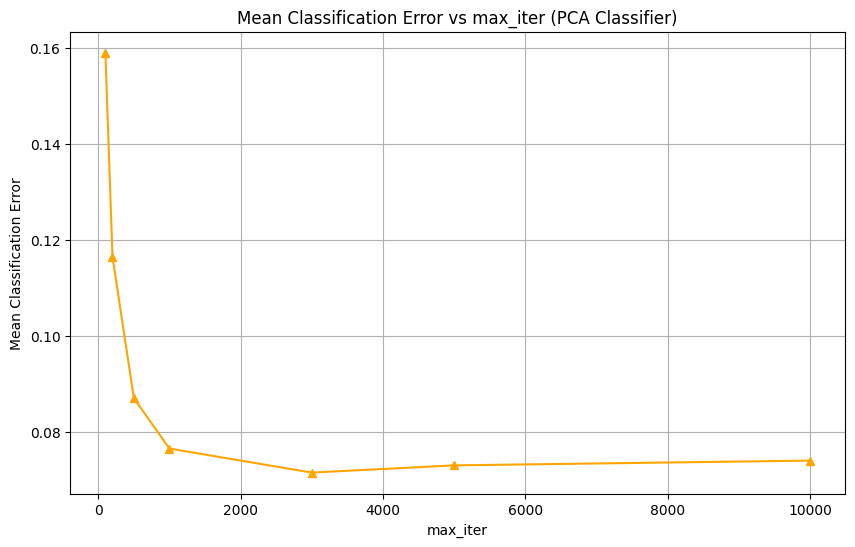

In [7]:
#PCA tuning with cross-validation
max_iter_values = [100, 200, 500, 1000, 3000, 5000, 10000]
repeats = 1
all_results = []

images, labels = read_mnist_txt("Numbers.txt")
flat_images = images.reshape(len(images), -1)
flat_images = StandardScaler().fit_transform(flat_images)

for max_iter in max_iter_values:
    print(max_iter)
    scores_iter = []

    for rep in range(repeats):
        scores = cross_validate(
            random_state=42 + rep,
            images=flat_images,
            labels=labels,
            train_fn=lambda X, y: train_PCA(X, y, max_iter=max_iter),
            predict_fn=predict_with_PCA,
            k_folds=5,
            metric_fn=accuracy_score
        )
        scores_iter.extend(scores)

    all_results.append(scores_iter)

pca_errors = [1 - np.mean(scores) for scores in all_results]

plt.figure(figsize=(10, 6))
plt.plot(max_iter_values, pca_errors, marker='^', linestyle='-', color='orange')
plt.title("Mean Classification Error vs max_iter (PCA Classifier)")
plt.xlabel("max_iter")
plt.ylabel("Mean Classification Error")
plt.grid(True)
plt.show()


C:\Users\Nils\AppData\Local\Temp\ipykernel_17864\2035251376.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_results, labels=max_iter_values, showfliers=False)


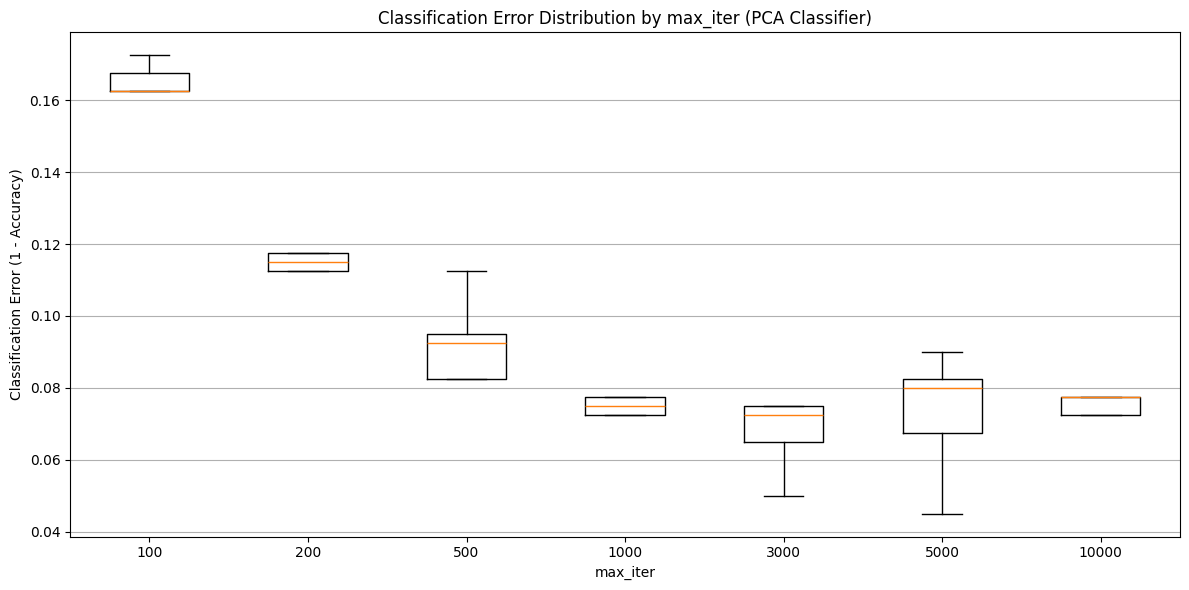

In [13]:
# Convert accuracy scores to errors before plotting
error_results = [[1 - score for score in scores] for scores in all_results]

plt.figure(figsize=(12, 6))
plt.boxplot(error_results, labels=max_iter_values, showfliers=False)
plt.title("Classification Error Distribution by max_iter (PCA Classifier)")
plt.xlabel("max_iter")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
